In [ ]:
# %% Load data and packages
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, Row
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StandardScaler, PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.mllib.feature import StandardScaler as StandardScalerRDD
from pyspark.mllib.linalg.distributed import RowMatrix
import pyspark.sql.functions as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


spark = SparkSession \
        .builder \
        .appName("dr_cluster") \
        .getOrCreate()

# Read Spotify data
df = spark.read.csv('/home/mikezhu/music/data/spotify_dataset.csv', header=True)


# Note potentially relevant features like danceability, energy, acousticness, etc.
df.columns

24/11/19 23:00:30 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


['id',
 'name',
 'popularity',
 'duration_ms',
 'explicit',
 'release_date',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'time_signature',
 'artist']

In [ ]:
# %% column names

'''
['id',
 'name',
 'popularity',
 'duration_ms',
 'explicit', #ignore
 'release_date',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',#ignore
 'valence',
 'tempo',
 'time_signature',
 'artist']
 '''

"\n['id',\n 'name',\n 'popularity',\n 'duration_ms',\n 'explicit', #ignore\n 'release_date',\n 'danceability',\n 'energy',\n 'key',\n 'loudness',\n 'mode',\n 'speechiness',\n 'acousticness',\n 'instrumentalness',\n 'liveness',#ignore\n 'valence',\n 'tempo',\n 'time_signature',\n 'artist']\n "

In [ ]:
# %% Data preprocessing

# identify potentially relevant features and add to a feature dataframe
feature_cols = [
    #'explicit',
    #'liveness',
    'duration_ms',
    'loudness',
    'key',
    'tempo', 
    'time_signature',
    'mode',
    'acousticness', 
    'instrumentalness',  
    'speechiness',
    'danceability', 
    'energy',
    'valence'
    ]

# select feature columns and numeric data as floats
df_features = df.select(*(F.col(c).cast("float").alias(c) for c in feature_cols),'id','name', 'artist') \
                         .dropna()
df_features = df_features.withColumn('features', F.array(*[F.col(c) for c in feature_cols])) \
                         .select('id','name', 'artist', 'features')

# convert features to dense vector format (expected by K-Means, PCA)
vectors = df_features.rdd.map(lambda row: Vectors.dense(row.features))
features = spark.createDataFrame(vectors.map(Row), ["features_unscaled"])

# scale features (some values like duration_ms are much larger than others)
standardizer = StandardScaler(inputCol="features_unscaled", outputCol="features")
model = standardizer.fit(features)
features = model.transform(features) \
                .select('features')

# persist in memory before fit model
features.persist()
features.printSchema()

root
 |-- features: vector (nullable = true)



In [ ]:
# %% K-means

# try different numbers of clusters to find optimal k
def find_optimal_kmeans(features, k_values=range(2, 13)):
    """
    Find optimal k for KMeans clustering using silhouette scores
    
    Args:
        features: DataFrame with feature vectors
        k_values: Range of k values to try
        
    Returns:
        optimal_k: Optimal number of clusters
        kmeans_predictions: Predictions using optimal k
        silhouettes: List of silhouette scores for each k
    """
    silhouettes = []
    
    for k in k_values:
        # train model
        kmeans = KMeans(k=k, seed=1)
        model = kmeans.fit(features)
        
        # make predictions
        predictions = model.transform(features)
        
        # evaluate clustering
        evaluator = ClusteringEvaluator()
        silhouette = evaluator.evaluate(predictions)
        silhouettes.append(silhouette)
        print(f"Silhouette score for k={k}: {silhouette}")

    # Plot silhouette scores
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, silhouettes, 'bo-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs Number of Clusters')
    plt.grid(True)
    
    # Add value labels on the points
    for k, silhouette in zip(k_values, silhouettes):
        plt.annotate(f'{silhouette:.3f}', 
                    (k, silhouette), 
                    textcoords="offset points", 
                    xytext=(0,10),
                    ha='center')
    
    plt.show()

    # find optimal k
    optimal_k = k_values[silhouettes.index(max(silhouettes))]
    print(f"\nOptimal number of clusters (k) = {optimal_k}")
    print(f"Best silhouette score = {max(silhouettes)}")
    
    # train final model with optimal k
    kmeans = KMeans(k=optimal_k, seed=1)
    kmeans_model = kmeans.fit(features)
    optimal_predictions = kmeans_model.transform(features)
    
    return optimal_k, optimal_predictions, silhouettes

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


24/11/19 23:00:46 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
24/11/19 23:00:46 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK
Component 1 explained variance: 0.2370
Cumulative explained variance: 0.2370
Component 2 explained variance: 0.2246
Cumulative explained variance: 0.4616
Component 3 explained variance: 0.1010
Cumulative explained variance: 0.5626
Component 4 explained variance: 0.0838
Cumulative explained variance: 0.6463
Component 5 explained variance: 0.0818
Cumulative explained variance: 0.7281
Component 6 explained variance: 0.0715
Cumulative explained variance: 0.7996
Component 7 explained variance: 0.0641
Cumulative explained variance: 0.8637
Component 8 explained variance: 0.0599
Cumulative explained variance: 0.9236
Component 9 explained variance: 0.0337
Cumulative explained variance: 0.9572
Component 10 explained variance: 0.0269
Cumulative explained variance: 0.9841
Component 

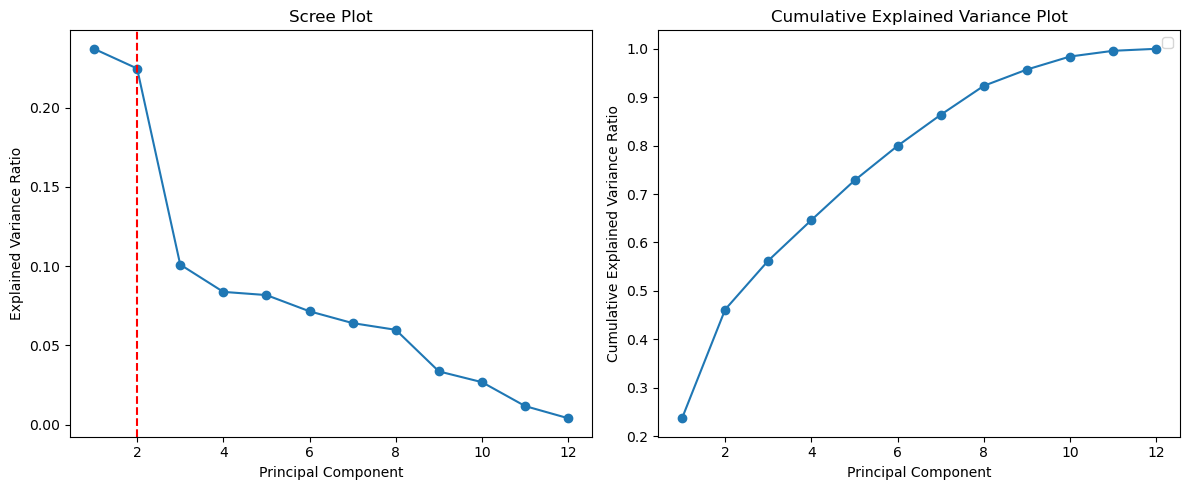

Optimal number of components: 2


Silhouette score for k=2: 0.5144790774116553


Silhouette score for k=3: 0.3628514767537176


Silhouette score for k=4: 0.6732810708951354
Silhouette score for k=5: 0.6230520584181463
Silhouette score for k=6: 0.5795857937291364


Silhouette score for k=7: 0.5419501669063124


Silhouette score for k=8: 0.5454295316709676


Silhouette score for k=9: 0.5385257996677854


Silhouette score for k=10: 0.5260631532484508


Silhouette score for k=11: 0.5151316605107933


Silhouette score for k=12: 0.54991901547966


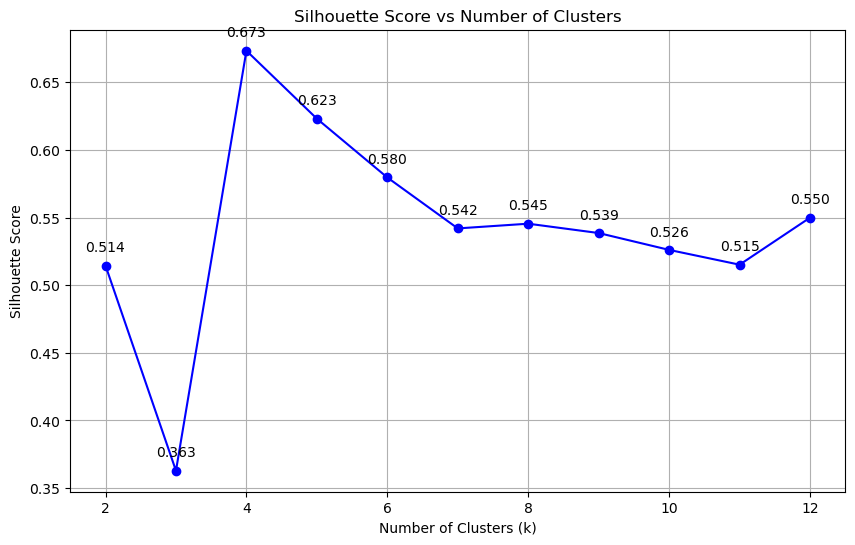


Optimal number of clusters (k) = 4
Best silhouette score = 0.6732810708951354


In [ ]:
# %% PCA-KMeans

def find_optimal_pca_components(features,threshold=0.9,k=None):
    """
    Find optimal number of PCA components by analyzing explained variance
    
    Args:
        features: DataFrame with feature vectors
        feature_cols: List of feature column names
        
    Returns:
        explained_variances: Array of explained variance ratios
        cumulative_variance: Array of cumulative explained variance ratios
    """
    n_features = features.first()["features"].size
    pca = PCA(k=n_features, inputCol="features", outputCol="pcaFeatures") 
    model = pca.fit(features)

    explained_variances = model.explainedVariance
    cumulative_variance = [sum(explained_variances[:i+1]) for i in range(len(explained_variances))]

    # Print variance explained by each component
    for i, var in enumerate(explained_variances):
        print(f"Component {i+1} explained variance: {var:.4f}")
        print(f"Cumulative explained variance: {cumulative_variance[i]:.4f}")

    # Find optimal number of components
    if k is None:
        optimal_n = next((i for i, cum_var in enumerate(cumulative_variance) if cum_var >= threshold), len(cumulative_variance))
    else:
        optimal_n = k

    # Plot explained variance analysis
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot scree plot
    ax1.plot(range(1, len(explained_variances) + 1), explained_variances, marker='o')
    ax1.set_xlabel('Principal Component')
    ax1.set_ylabel('Explained Variance Ratio')
    ax1.set_title('Scree Plot')
    ax1.axvline(x=optimal_n, color='r', linestyle='--', label=f'Optimal number of components ({optimal_n})')

    # Plot cumulative variance
    ax2.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
    # Add threshold line at 0.8
    if k is None:
        ax2.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold ({threshold})')
    ax2.legend()
    ax2.set_xlabel('Principal Component')
    ax2.set_ylabel('Cumulative Explained Variance Ratio')
    ax2.set_title('Cumulative Explained Variance Plot')

    plt.tight_layout()
    plt.show()

    if k is None:
        print(f"Optimal number of components: {optimal_n}, threshold: {threshold}")
    else:
        print(f"Optimal number of components: {optimal_n}")

    # transform features according to optimal number of components
    pca = PCA(k=optimal_n, inputCol="features", outputCol="pcaFeatures") 
    model = pca.fit(features)

    pca_results = model.transform(features) \
                        .select('pcaFeatures')
    
    pca_features = pca_results.rdd.map(lambda row: Vectors.dense(row.pcaFeatures))
    pca_features = spark.createDataFrame(pca_features.map(Row), ["features"])

    return optimal_n, pca_features, explained_variances, cumulative_variance
# 1. PCA: find optimal number of components
optimal_n, features_pca, explained_variances, cumulative_variance = find_optimal_pca_components(features,k=2)
# 2. KMeans: find optimal k, based on PCA-transformed features
features_pca.persist()
optimal_k_pca, kmeans_predictions_pca, silhouettes_pca = find_optimal_kmeans(features_pca)

In [ ]:
#%% merge cluster results

# merge to get cluster results
merged_results = kmeans_predictions_pca.withColumn("tmp_id", F.monotonically_increasing_id()) \
            .join(df_features.withColumn("tmp_id", F.monotonically_increasing_id()).withColumnRenamed("features", "raw_features"), on="tmp_id", how="inner").drop("tmp_id") \
            .join(df,on=["id","name","artist"],how="inner")
merged_results.show()
merged_results.count()
#examine cluster distribution
merged_results.groupby('prediction') \
               .count() \
               .show()
cluster_results=merged_results.filter(F.col("prediction") != 3)
cluster_results.groupby('prediction') \
               .count() \
               .show()

+--------------------+---------------------+--------------------+--------------------+----------+--------------------+----------+-----------+--------+------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+
|                  id|                 name|              artist|            features|prediction|        raw_features|popularity|duration_ms|explicit|release_date|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|time_signature|
+--------------------+---------------------+--------------------+--------------------+----------+--------------------+----------+-----------+--------+------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+
|000KblXP5csWFFFsD...|               Podrás|       Tamara Castro|[0.83646507234205...|         2|[240013.0, -5.0, ...|        35|     240013|   fals

+----------+------+
|prediction| count|
+----------+------+
|         1|141078|
|         3|   969|
|         2|269051|
|         0|331126|
+----------+------+



+----------+------+
|prediction| count|
+----------+------+
|         1|141078|
|         2|269051|
|         0|331126|
+----------+------+



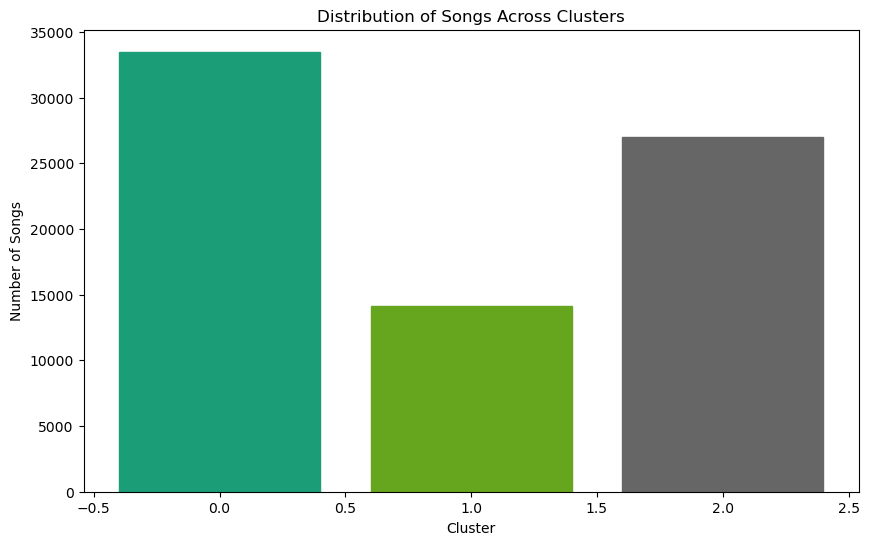

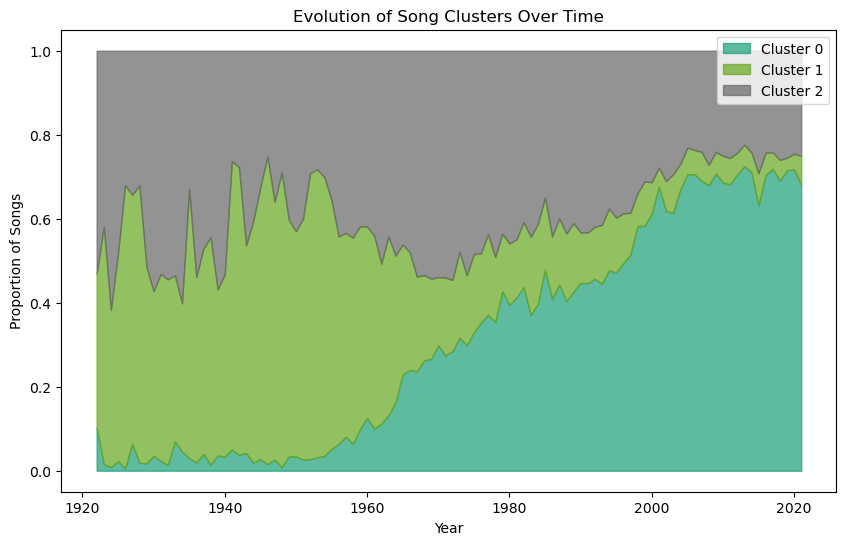

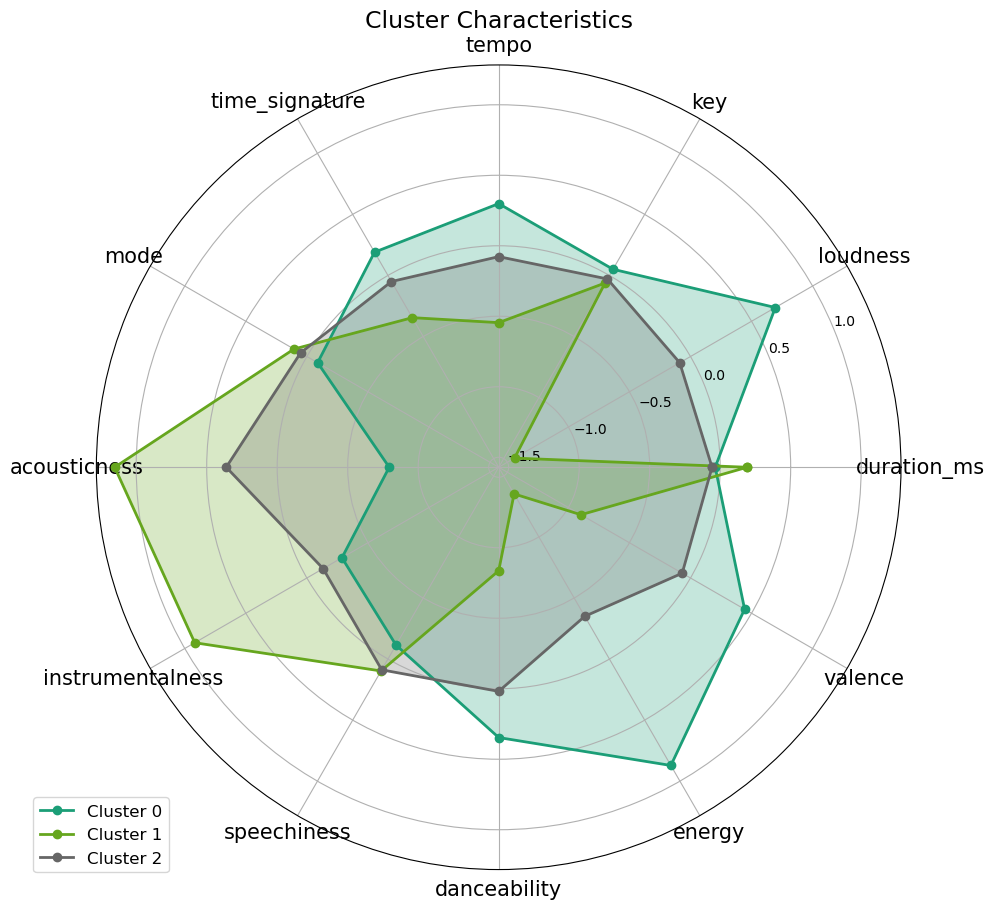

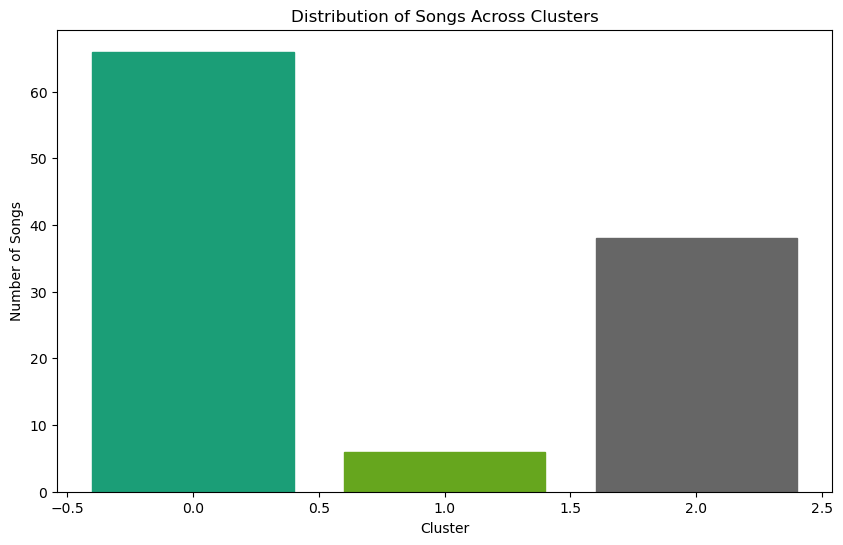

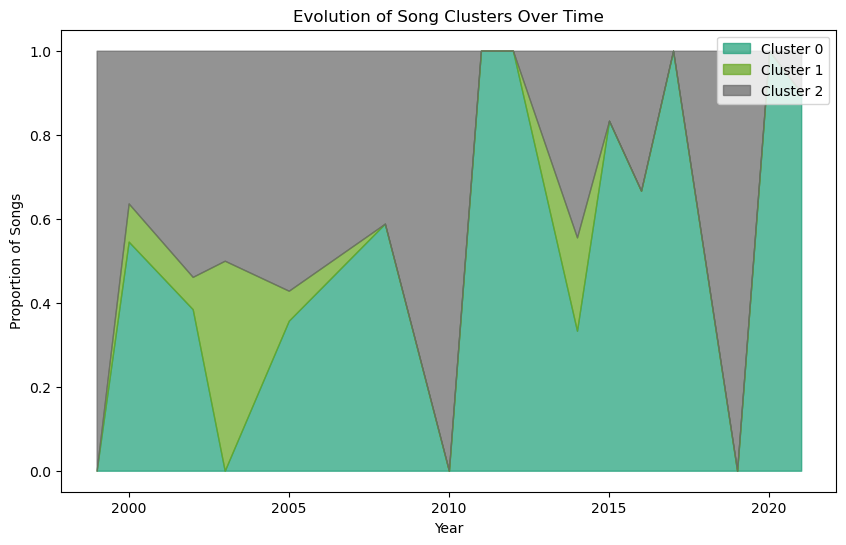

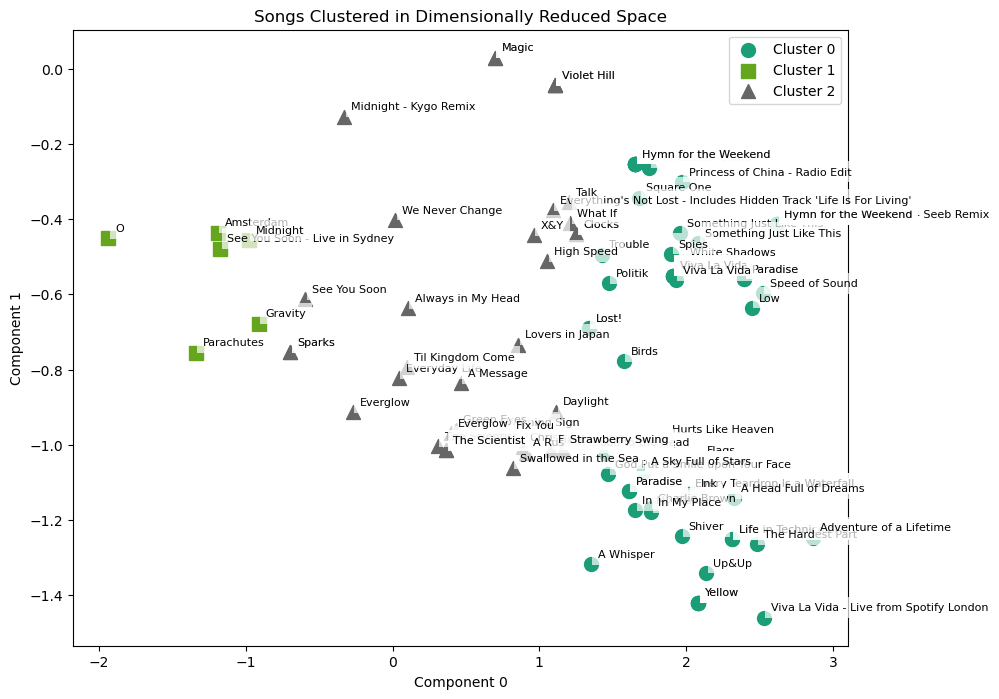

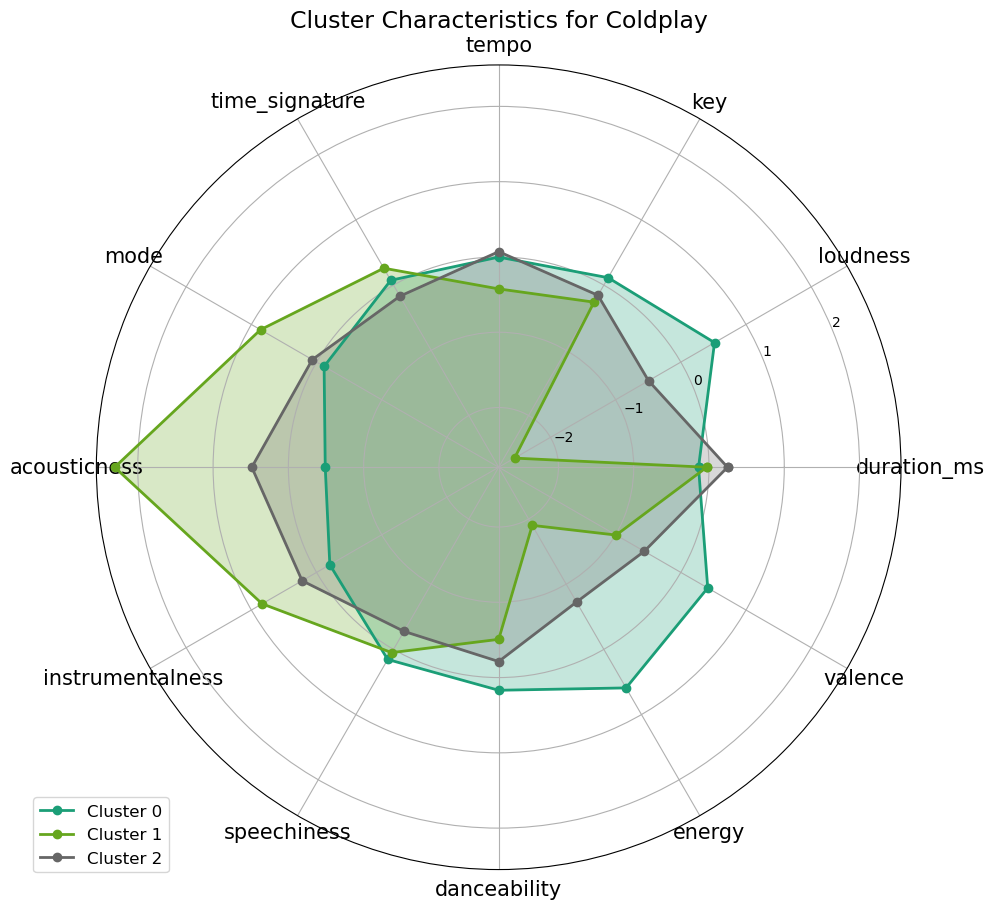

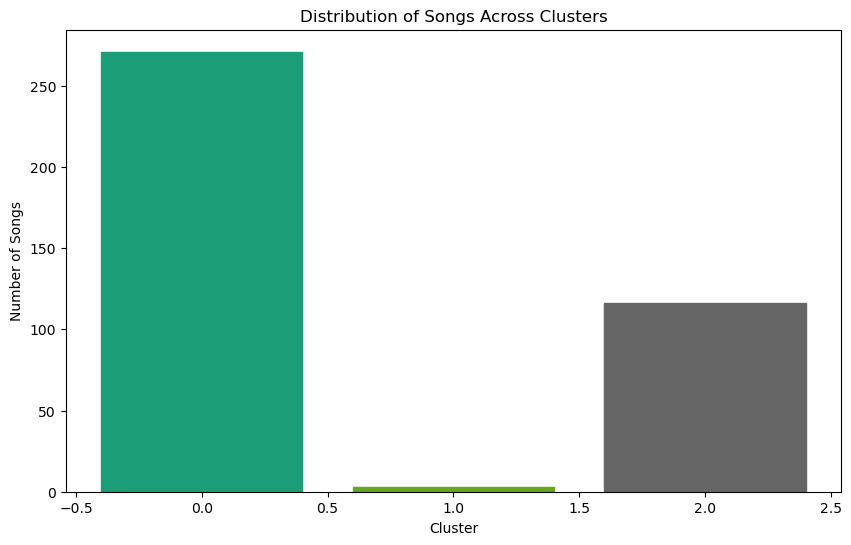

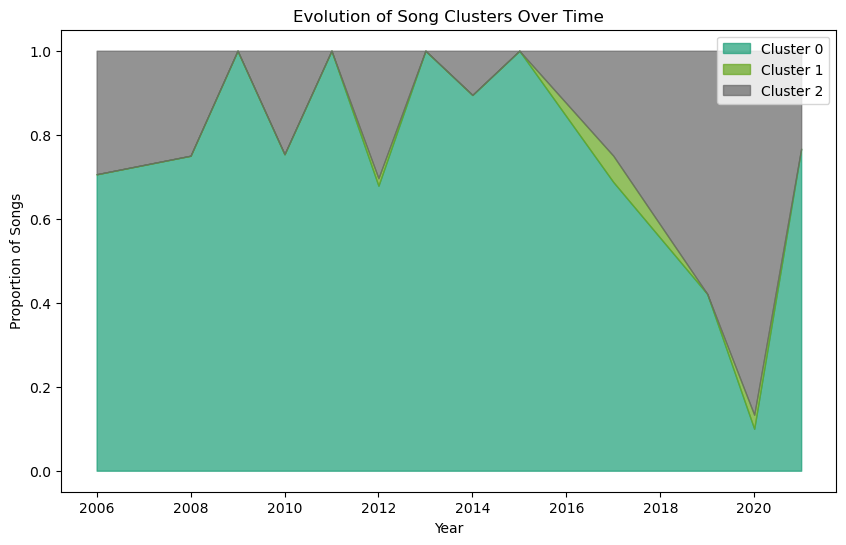

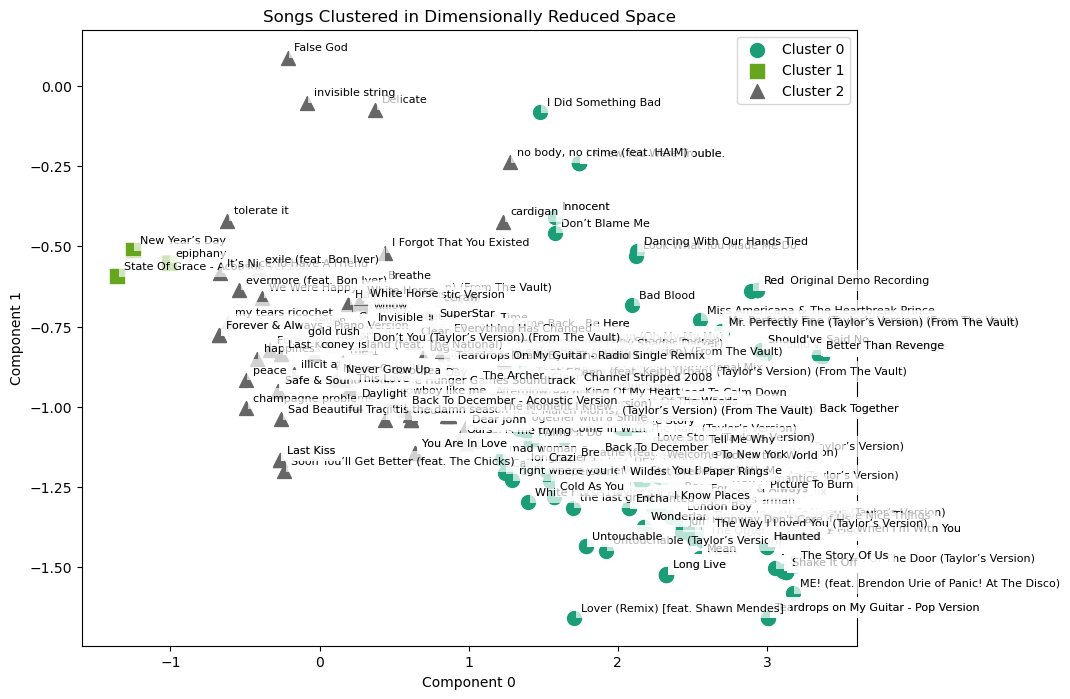

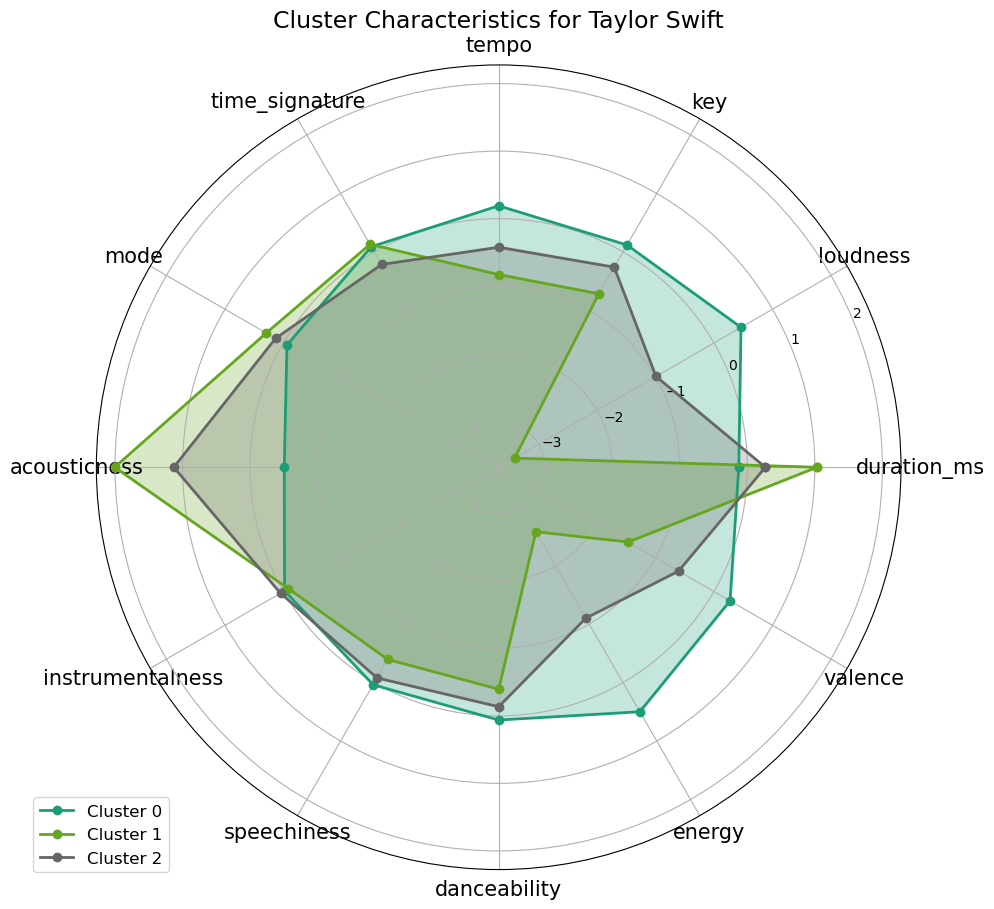

duration_ms  loudness       key     tempo  time_signature  \
prediction                                                              
0             -0.125909  0.462022  0.119185  0.190379        0.090160   
1              1.032603 -3.410584 -0.714656 -0.827789        0.130361   
2              0.267445 -0.991175 -0.259959 -0.423357       -0.214003   

                mode  acousticness  instrumentalness  speechiness  \
prediction                                                          
0          -0.060750     -0.505860         -0.020207     0.038217   
1           0.293478      2.005313         -0.085194    -0.395720   
2           0.134334      1.129933          0.049412    -0.079050   

            danceability    energy   valence  
prediction                                    
0               0.062052  0.499518  0.275396  
1              -0.394282 -2.578196 -1.466300  
2              -0.134770 -1.100301 -0.605460

In [ ]:
#%% visualization

def exact_to_pd(cluster_full_data,artist_name=None,sample_size=0.1,seed=None):
    '''extract a subset of data, for visualization'''
    num_clusters = cluster_full_data.select('prediction').distinct().count()
    colors = plt.cm.Dark2(np.linspace(0, 1, num_clusters))
    if artist_name is None:
        if seed is None:
            cluster_data = cluster_full_data.sample(False, sample_size)  
        else:
            cluster_data = cluster_full_data.sample(False, sample_size, seed=seed)  
    else:
        cluster_data = cluster_full_data.filter(F.col("artist") == artist_name)
    cluster_data = cluster_data.toPandas()
    cluster_data['year'] = pd.to_datetime(cluster_data['release_date']).dt.year
    return num_clusters,colors,cluster_data

def plot_cluster_distribution(cluster_data,artist_name=None,sample_size=0.1,seed=None):
    """Plot distribution of songs across clusters"""
    num_clusters,colors,cluster_data=exact_to_pd(cluster_data,artist_name,sample_size,seed)
 
    all_clusters = pd.Series(0, index=range(num_clusters))
    cluster_counts = cluster_data['prediction'].value_counts()
    cluster_counts = cluster_counts.combine_first(all_clusters)
    cluster_counts = cluster_counts.sort_index()
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(cluster_counts.index, cluster_counts.values)
    for i, bar in enumerate(bars):
        bar.set_color(colors[i])
        
    plt.xlabel('Cluster')
    plt.ylabel('Number of Songs')
    plt.title(f'Distribution of Songs Across Clusters')
    plt.show()
    
    return cluster_counts

def plot_cluster_evolution(cluster_data, artist_name=None, sample_size=0.1, seed=None):
    """Plot evolution of clusters over time"""
    num_clusters, colors, cluster_data = exact_to_pd(cluster_data, artist_name, sample_size, seed)
    
    # Calculate proportion of each cluster per year
    yearly_proportions = cluster_data.pivot_table(
        index='year',
        columns='prediction',
        aggfunc='size',
        fill_value=0
    )
    yearly_proportions = yearly_proportions.div(yearly_proportions.sum(axis=1), axis=0)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot each cluster separately to ensure correct color mapping
    bottom = np.zeros(len(yearly_proportions))
    for cluster in range(num_clusters):
        if cluster in yearly_proportions.columns:
            values = yearly_proportions[cluster].values
            ax.fill_between(yearly_proportions.index, bottom, bottom + values, 
                          alpha=0.7, label=f'Cluster {cluster}',
                          color=colors[cluster])
            bottom += values
    
    plt.xlabel('Year')
    plt.ylabel('Proportion of Songs')
    plt.title('Evolution of Song Clusters Over Time')
    plt.legend()
    plt.show()

def plot_cluster_scatter(cluster_data, artist_name=None, dim_1=0, dim_2=1,sample_size=0.1,seed=None):
    """Plot scatter of clusters in PCA space"""
    num_clusters, colors,cluster_data=exact_to_pd(cluster_data, artist_name,sample_size,seed)
    markers = ['o', 's', '^', 'v', 'D', 'p', 'h']
    plt.figure(figsize=(10, 8))
    for cluster in range(num_clusters):
        plot_data = cluster_data[cluster_data["prediction"] == cluster]
        plt.scatter(plot_data["features"].apply(lambda x: float(x[dim_1])),
                   plot_data["features"].apply(lambda x: float(x[dim_2])),
                   c=[colors[cluster]], 
                   marker=markers[cluster % len(markers)],
                   label=f'Cluster {cluster}',
                   s=100)
        for _, row in plot_data.iterrows():
            plt.annotate(row["name"], 
                        (float(row["features"][dim_1]), float(row["features"][dim_2])),
                    xytext=(5, 5),
                        textcoords='offset points',
                        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7),
                        fontsize=8)
    plt.xlabel(f"Component {dim_1}")
    plt.ylabel(f"Component {dim_2}")
    plt.title("Songs Clustered in Dimensionally Reduced Space")
    plt.legend()
    plt.show()

def plot_cluster_radar(cluster_data, artist_name=None,sample_size=0.1,seed=None):
    """
    Create a radar plot to compare cluster centroids with standardized features
    
    Args:
        cluster_data: DataFrame with cluster predictions and features
        artist_name: Optional artist name to filter data
    """
    # Extract data and get number of clusters
    num_clusters, colors, cluster_data = exact_to_pd(cluster_data, artist_name,sample_size,seed)
    
    # Get feature values from the features column
    feature_values = pd.DataFrame(cluster_data['raw_features'].tolist(), 
                                columns=feature_cols)
    
    # Calculate global means and standard deviations for standardization
    global_means = feature_values[feature_cols].mean()
    global_stds = feature_values[feature_cols].std()
    
    # Standardize features
    standardized_values = feature_values.copy()
    for col in feature_cols:
        if global_stds[col] > 0:  # Avoid division by zero
            standardized_values[col] = (feature_values[col] - global_means[col]) / global_stds[col]
        else:
            standardized_values[col] = N
    
    # Add prediction column
    standardized_values['prediction'] = cluster_data['prediction']
    
    # Calculate mean values for each cluster using standardized features
    cluster_means = standardized_values.groupby('prediction')[feature_cols].mean()
    
    # Set up the angles for radar plot
    angles = np.linspace(0, 2*np.pi, len(feature_cols), endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))  # Close the circle
    
    # Set up the plot
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    # Plot data for each cluster
    for cluster in range(num_clusters):
        if cluster in cluster_means.index:
            values = cluster_means.loc[cluster].values
            values = np.concatenate((values, [values[0]]))  # Close the polygon
            
            ax.plot(angles, values, 'o-', linewidth=2, 
                   label=f'Cluster {cluster}', 
                   color=colors[cluster])
            ax.fill(angles, values, alpha=0.25, color=colors[cluster])

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(feature_cols, size=15)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), fontsize=12)
    title = "Cluster Characteristics"
    if artist_name:
        title += f" for {artist_name}"
    plt.title(title, fontsize=17)
    plt.tight_layout()
    plt.show()
    
    return cluster_means


#global
plot_cluster_distribution(cluster_results)
plot_cluster_evolution(cluster_results)
plot_cluster_radar(cluster_results)
#plot_cluster_scatter(cluster_results) # too many points
#individual
plot_cluster_distribution(cluster_results,"Coldplay")
plot_cluster_evolution(cluster_results,"Coldplay")
plot_cluster_scatter(cluster_results,"Coldplay")
plot_cluster_radar(cluster_results,"Coldplay")

plot_cluster_distribution(cluster_results,"Taylor Swift")
plot_cluster_evolution(cluster_results,"Taylor Swift")
plot_cluster_scatter(cluster_results,"Taylor Swift")
plot_cluster_radar(cluster_results,"Taylor Swift")

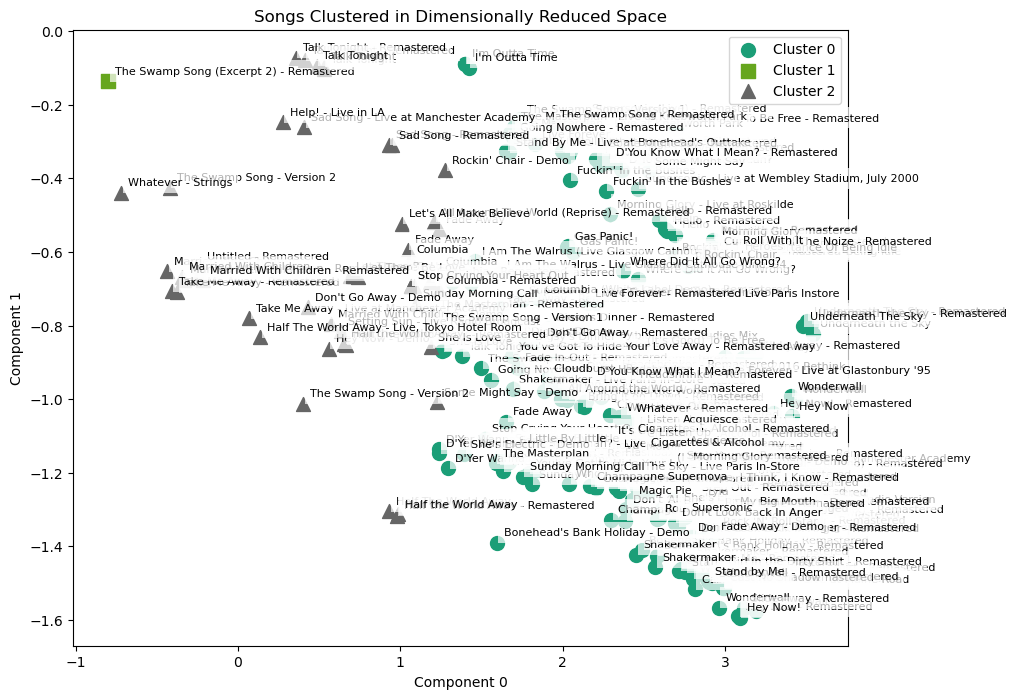

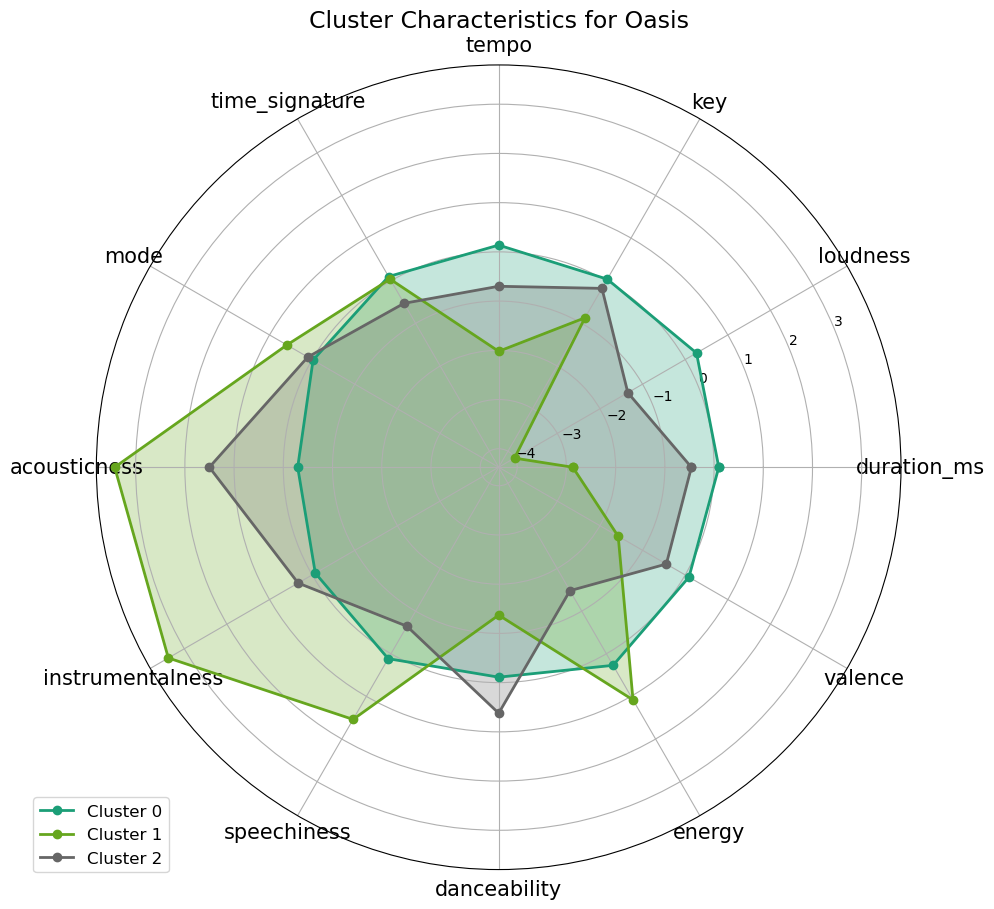

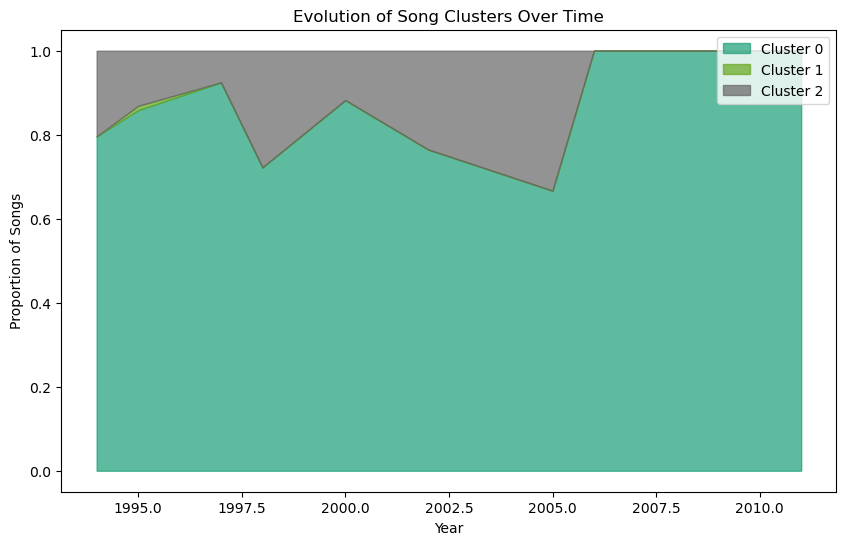

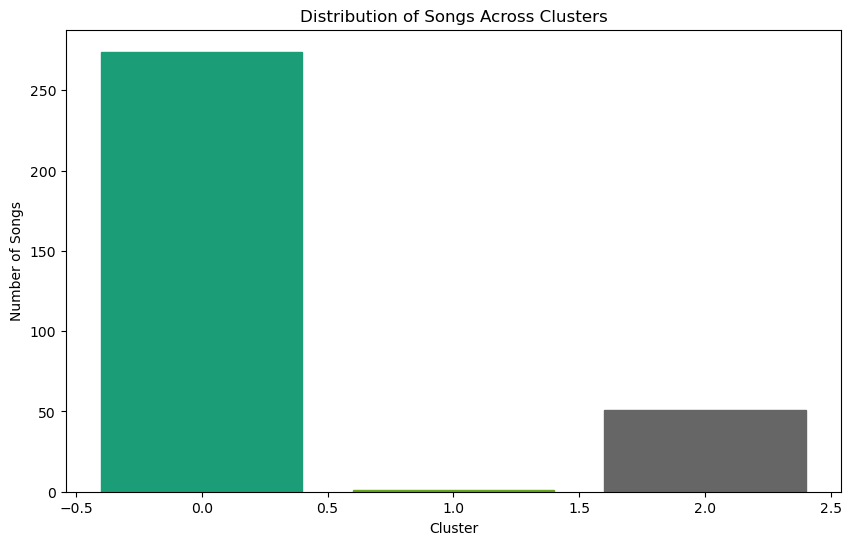

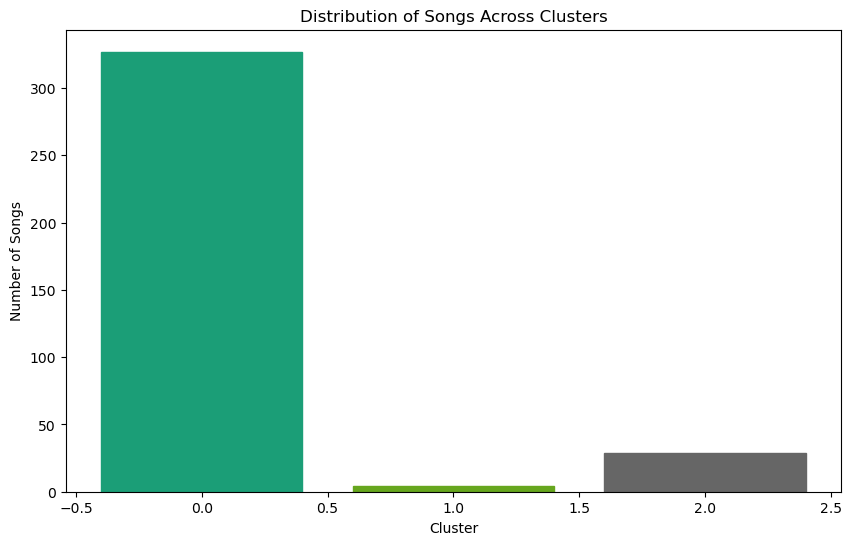

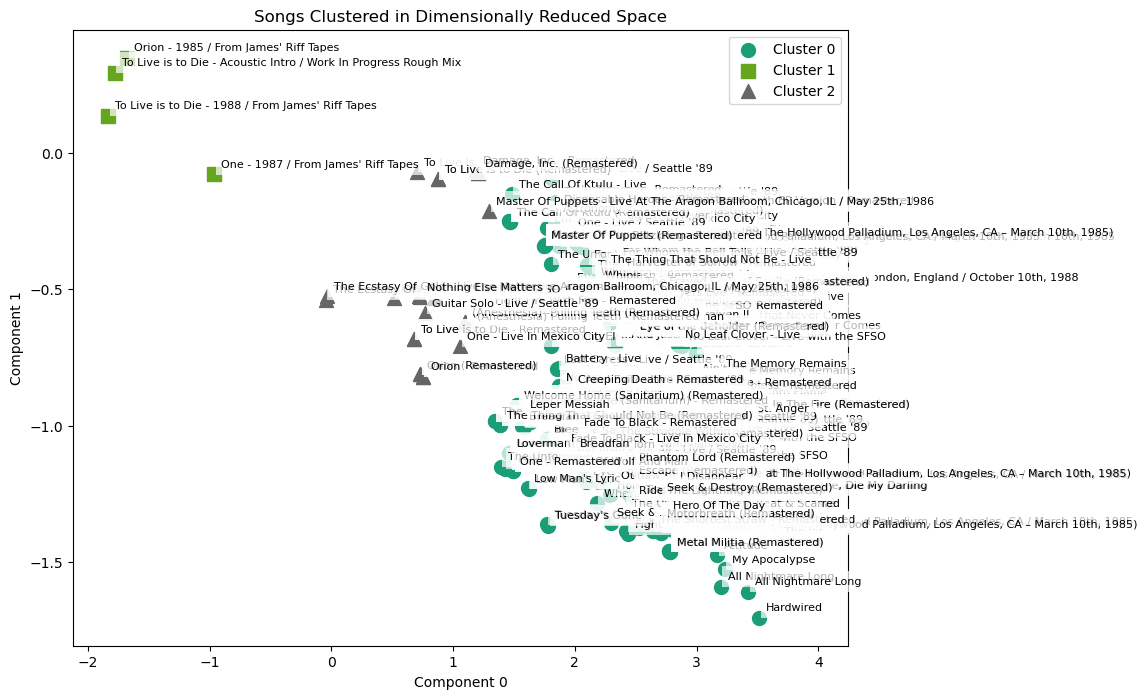

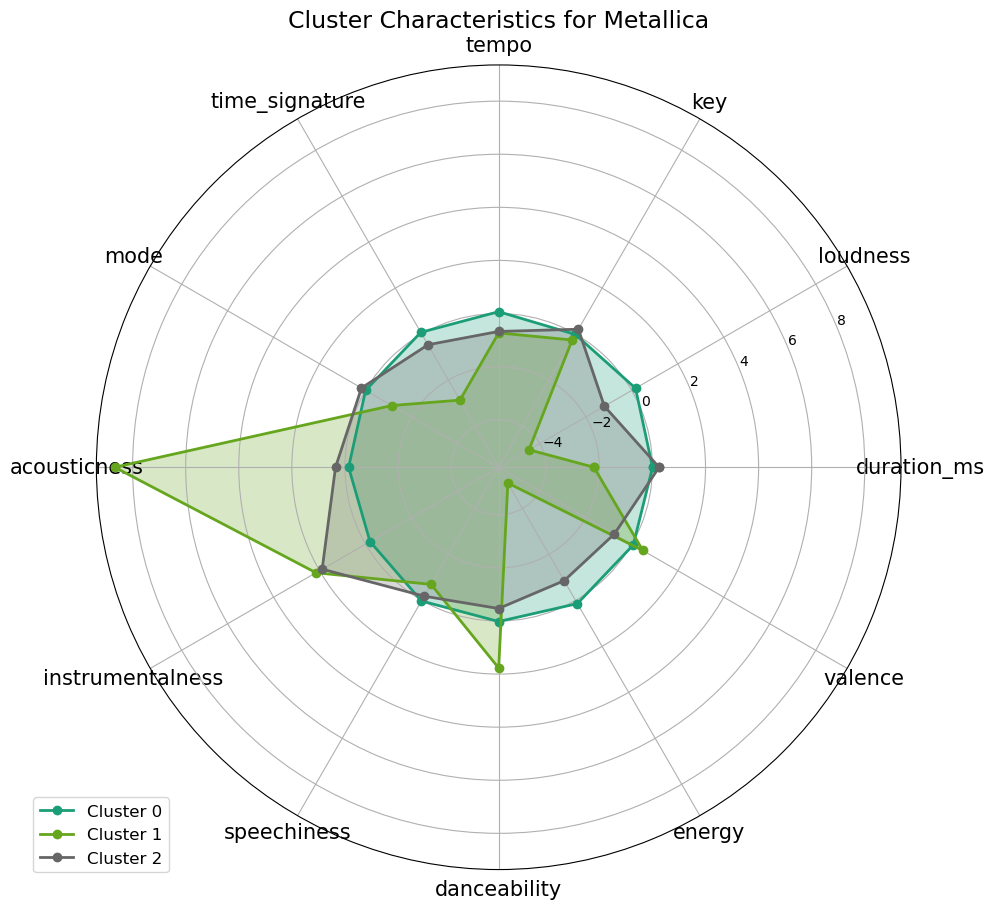

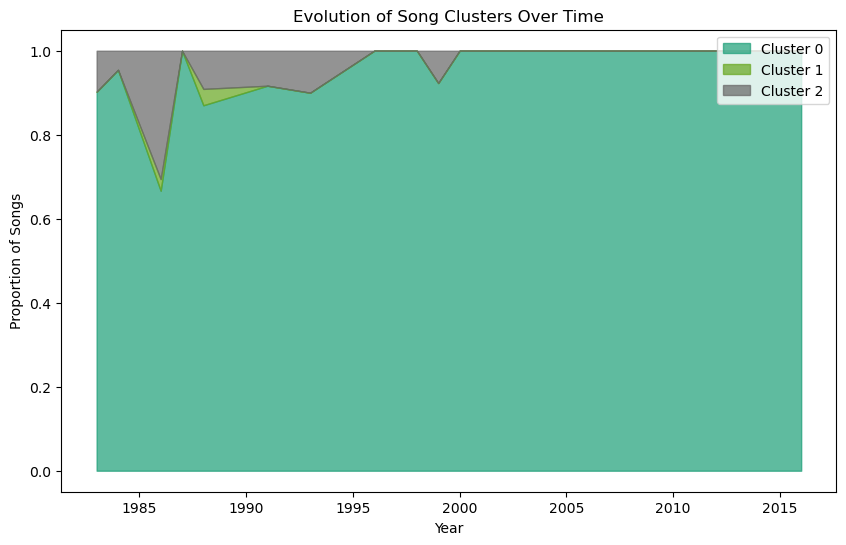

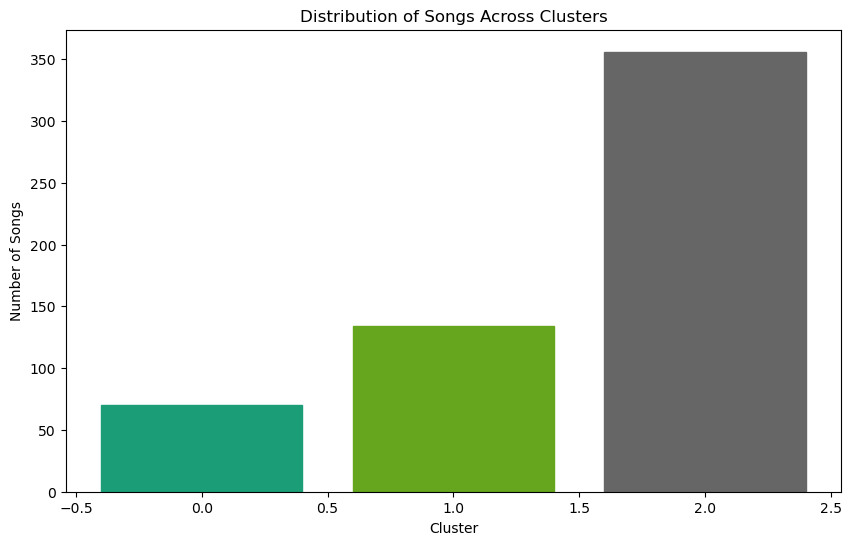

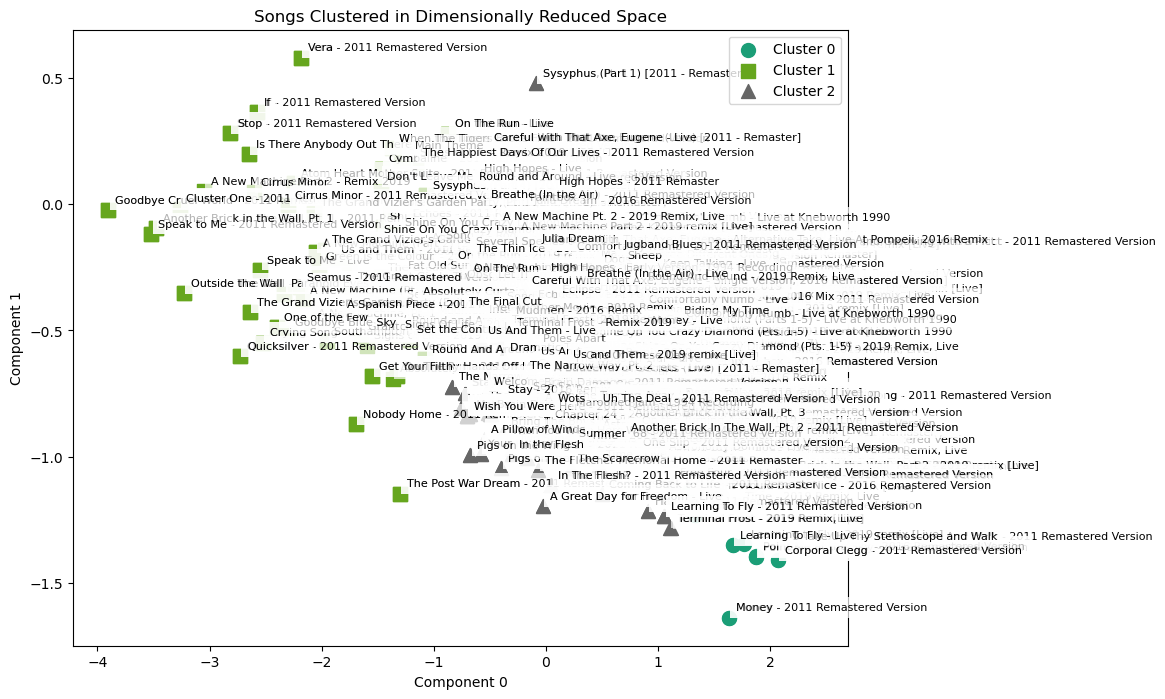

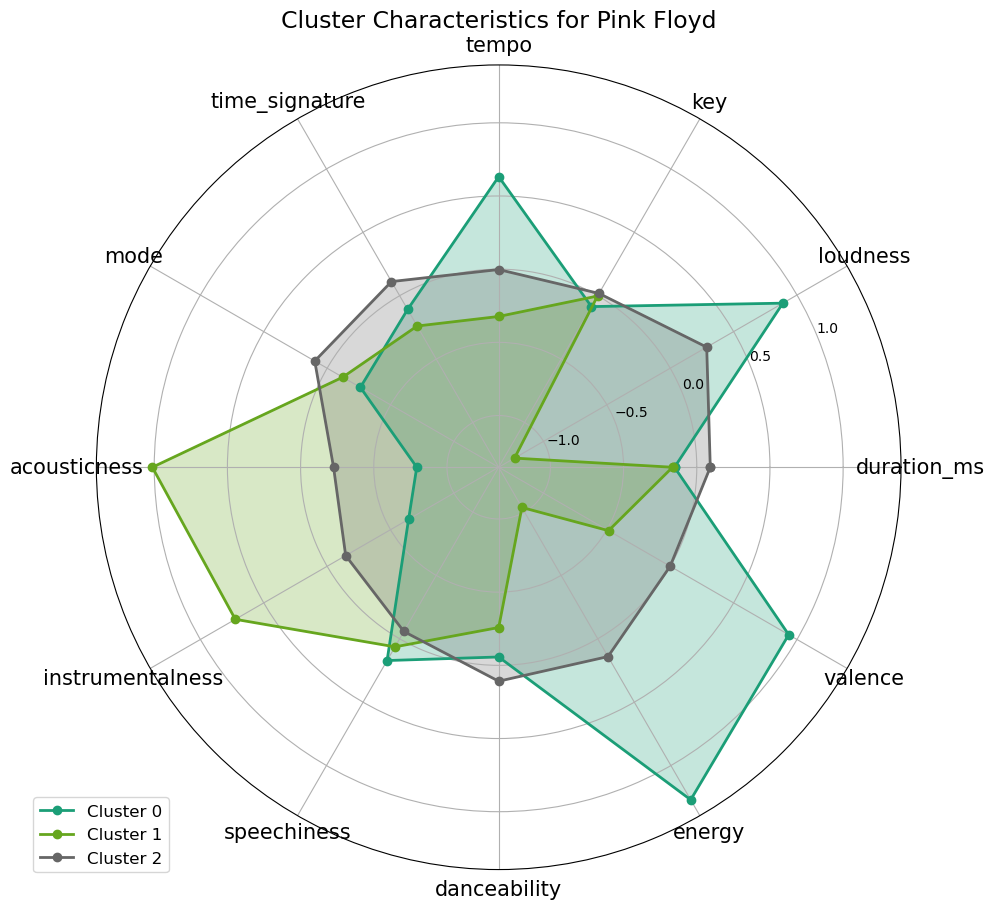

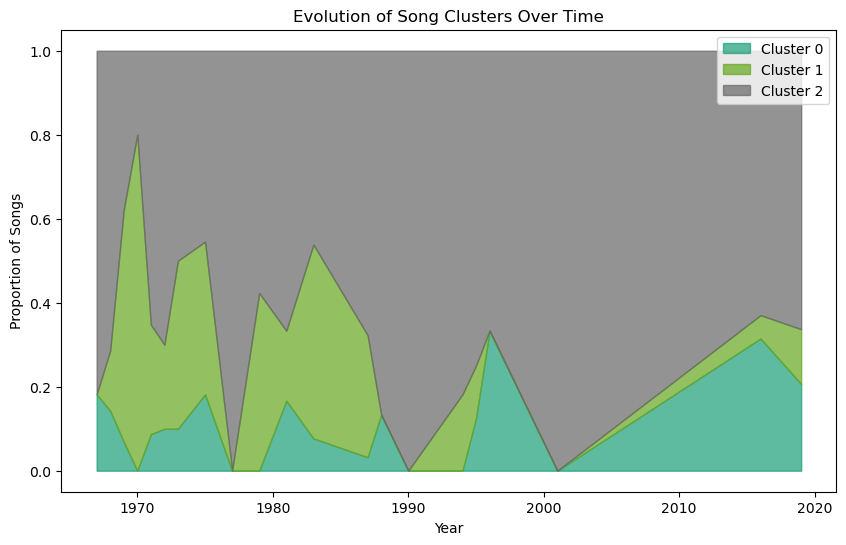

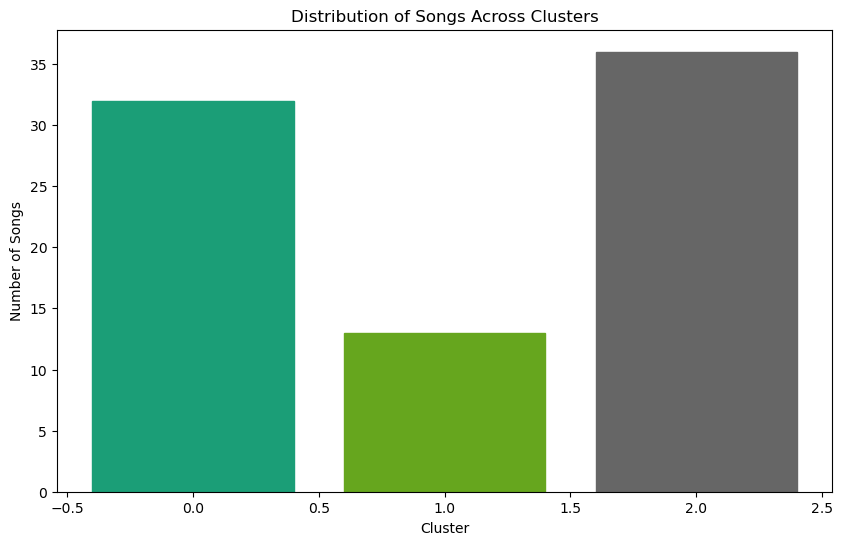

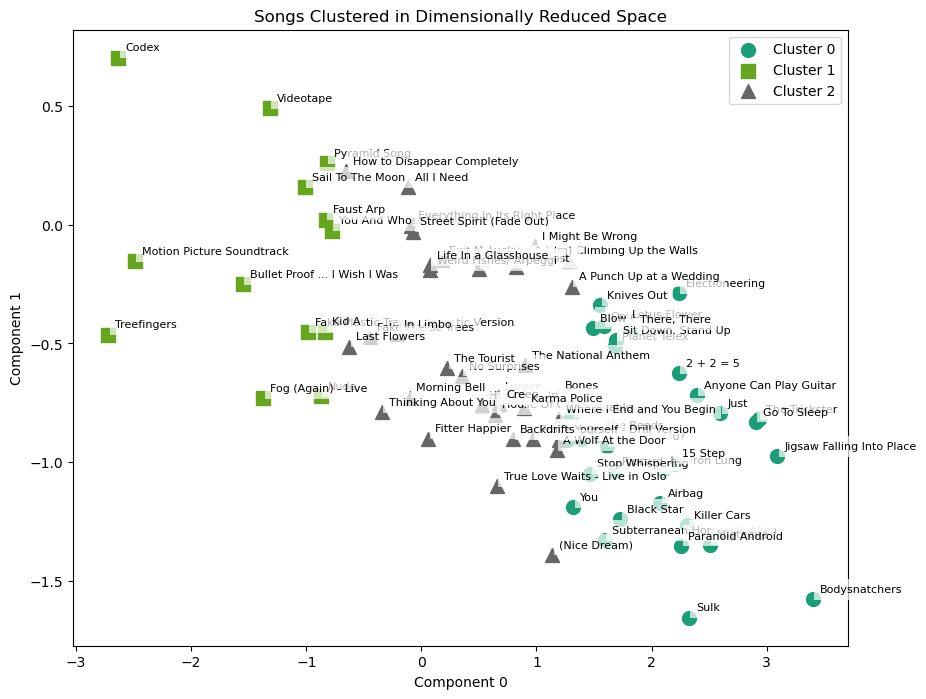

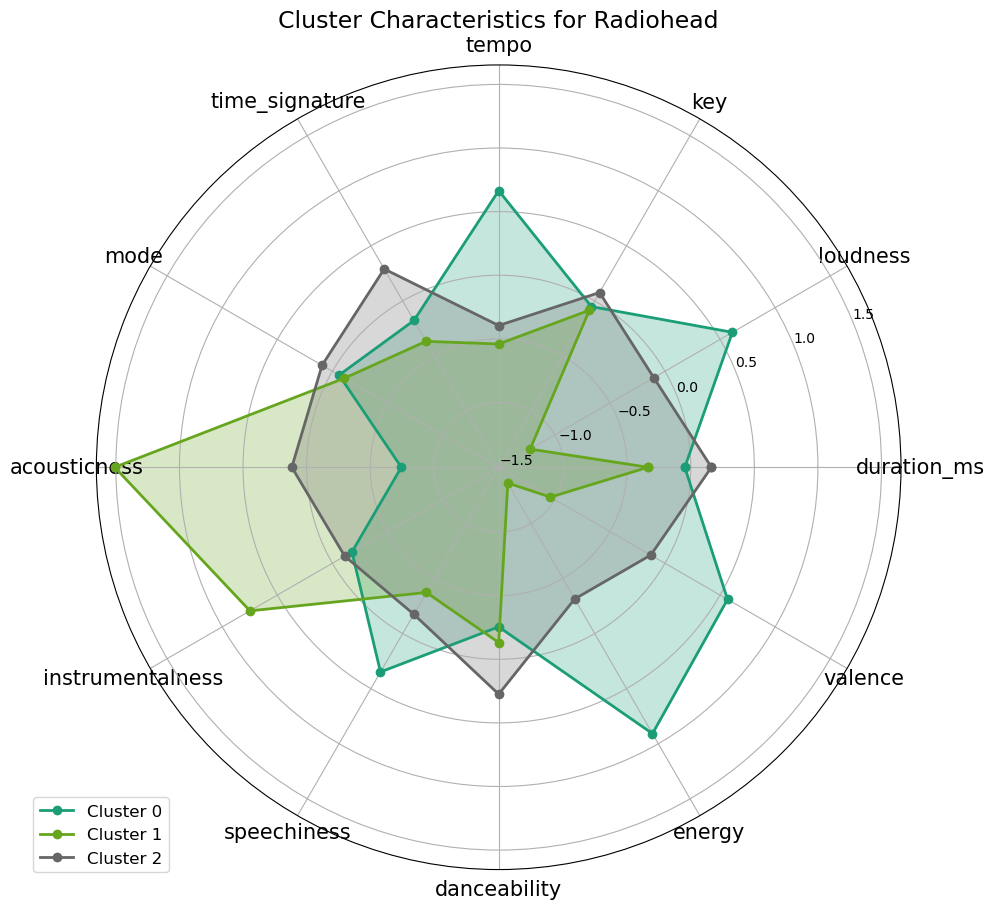

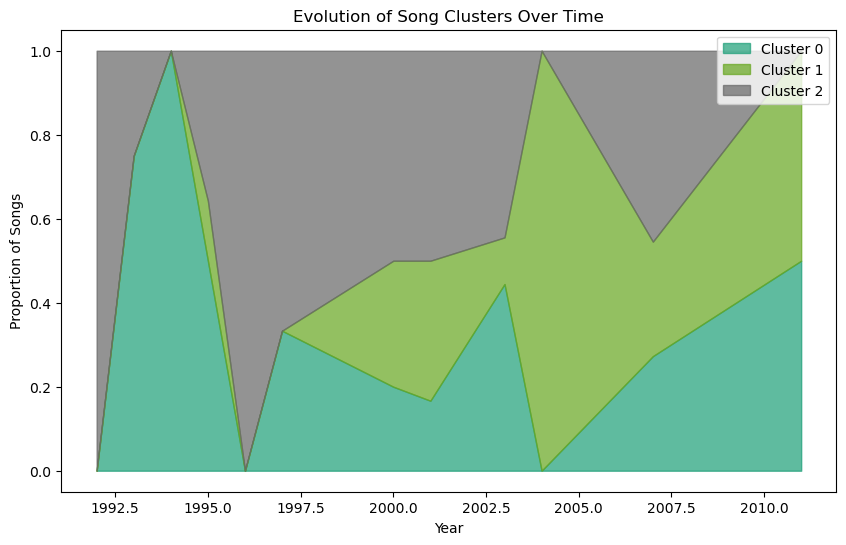

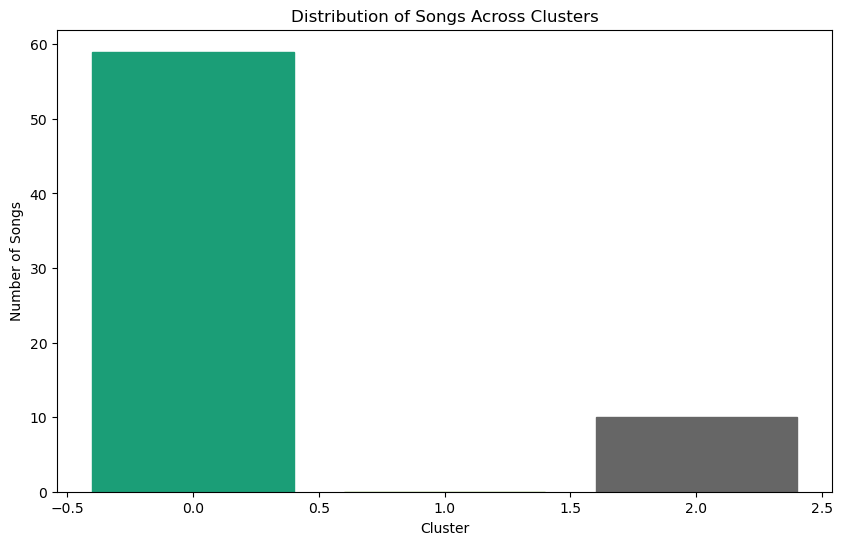

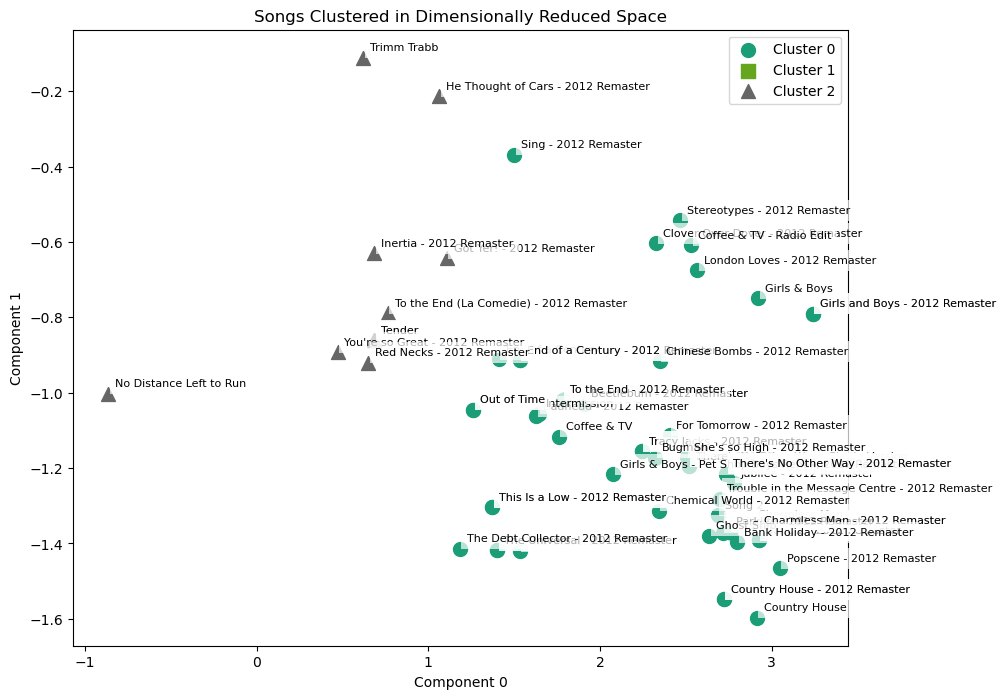

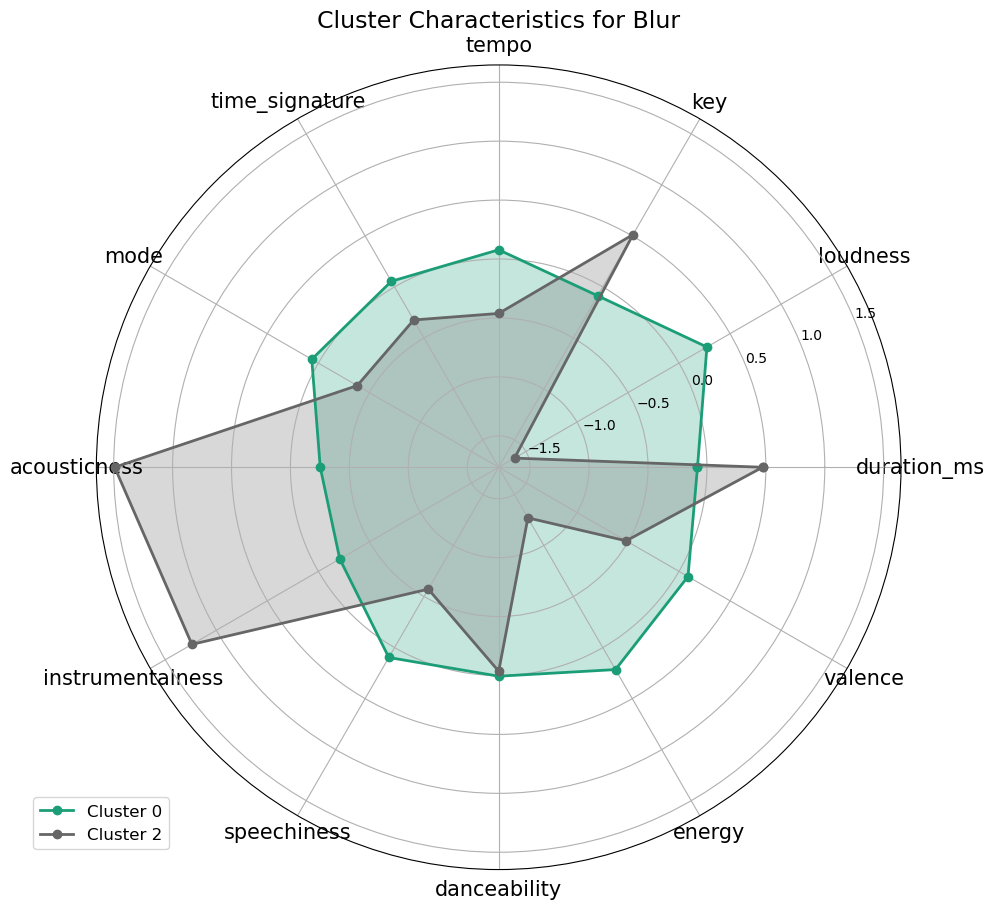

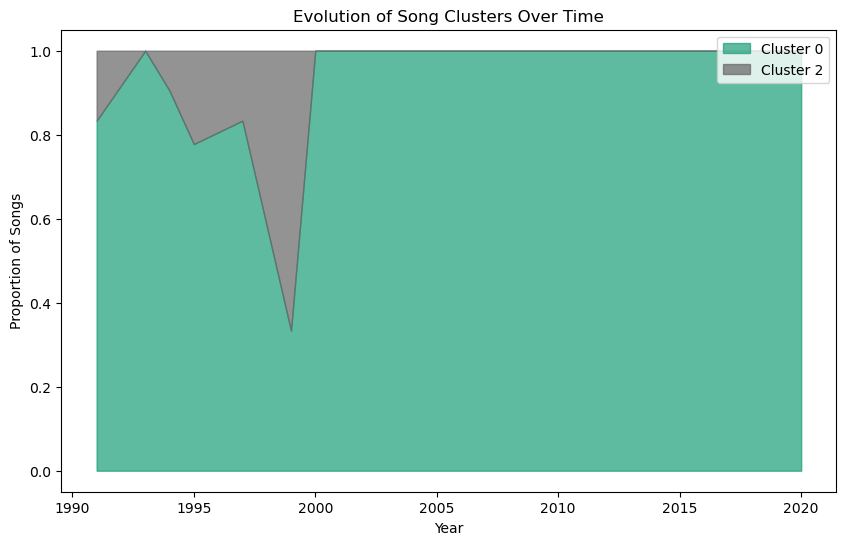

In [ ]:
# %% more artists

plot_cluster_scatter(cluster_results,"Oasis")
plot_cluster_radar(cluster_results,"Oasis")
plot_cluster_evolution(cluster_results,"Oasis")
plot_cluster_distribution(cluster_results,"Oasis")
plot_cluster_distribution(cluster_results,"Metallica")
plot_cluster_scatter(cluster_results,"Metallica")
plot_cluster_radar(cluster_results,"Metallica")
plot_cluster_evolution(cluster_results,"Metallica")
plot_cluster_distribution(cluster_results,"Pink Floyd")
plot_cluster_scatter(cluster_results,"Pink Floyd")
plot_cluster_radar(cluster_results,"Pink Floyd")
plot_cluster_evolution(cluster_results,"Pink Floyd")
plot_cluster_distribution(cluster_results,"Radiohead")
plot_cluster_scatter(cluster_results,"Radiohead")
plot_cluster_radar(cluster_results,"Radiohead")
plot_cluster_evolution(cluster_results,"Radiohead")
plot_cluster_distribution(cluster_results,"Blur")
plot_cluster_scatter(cluster_results,"Blur")
plot_cluster_radar(cluster_results,"Blur")
plot_cluster_evolution(cluster_results,"Blur")

In [ ]:
# %% Load data and packages
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, Row
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StandardScaler, PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.mllib.feature import StandardScaler as StandardScalerRDD
from pyspark.mllib.linalg.distributed import RowMatrix
import pyspark.sql.functions as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


spark = SparkSession \
        .builder \
        .appName("dr_cluster") \
        .getOrCreate()

# Read Spotify data
df = spark.read.csv('/home/mikezhu/music/data/spotify_dataset.csv', header=True)


# Note potentially relevant features like danceability, energy, acousticness, etc.
df.columns

In [ ]:
# %% column names

'''
['id',
 'name',
 'popularity',
 'duration_ms',
 'explicit', #ignore
 'release_date',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',#ignore
 'valence',
 'tempo',
 'time_signature',
 'artist']
 '''

In [ ]:
# %% Data preprocessing

# identify potentially relevant features and add to a feature dataframe
feature_cols = [
    #'explicit',
    #'liveness',
    'duration_ms',
    'loudness',
    'key',
    'tempo', 
    'time_signature',
    'mode',
    'acousticness', 
    'instrumentalness',  
    'speechiness',
    'danceability', 
    'energy',
    'valence'
    ]

# select feature columns and numeric data as floats
df_features = df.select(*(F.col(c).cast("float").alias(c) for c in feature_cols),'id','name', 'artist') \
                         .dropna()
df_features = df_features.withColumn('features', F.array(*[F.col(c) for c in feature_cols])) \
                         .select('id','name', 'artist', 'features')

# convert features to dense vector format (expected by K-Means, PCA)
vectors = df_features.rdd.map(lambda row: Vectors.dense(row.features))
features = spark.createDataFrame(vectors.map(Row), ["features_unscaled"])

# scale features (some values like duration_ms are much larger than others)
standardizer = StandardScaler(inputCol="features_unscaled", outputCol="features")
model = standardizer.fit(features)
features = model.transform(features) \
                .select('features')

# persist in memory before fit model
features.persist()
features.printSchema()